#Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
import pickle
import json

#Data preparations

##Roboflow Dataset manually labeled

In [ ]:
# shutil.rmtree('/content/DEfDO-3')

In [ ]:
!pip install roboflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="xxGULUboEznOQ9JG9dDc")
project = rf.workspace("defdo").project("defdo")
version = project.version(3)
dataset = version.download("yolov8-obb")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DEfDO-3 in yolov8-obb:: 100%|██████████| 503/503 [00:00<00:00, 6103.87it/s]


In [ ]:
import os
len(os.listdir('DEfDO-3/train/images'))

222

In [ ]:
## Renaming every file in each of the two folders '/content/DEfDO-3/train/labels' and '/content/DEfDO-3/valid/labels'  in a way that it only takes all letters before the underscore symbol

# modes = ['train', 'valid']

# for mode in modes:
#   for filename in os.listdir(f'/content/DEfDO-3/{mode}/labels'):
#     if '_' in filename:
#       new_filename = filename.split('_')[0] + '.txt'
#       os.rename(f'/content/DEfDO-3/{mode}/labels/' + filename, f'/content/DEfDO-3/{mode}/labels/' + new_filename)

'''Big mistake ! the rest of the name in each file we tried to remove is
    the only way to distinguish between the original image
    and the ones coming from the data augmentation process.
    This mistake affected the Box Loss.
'''



'Big mistake ! the rest in the name we tried to remove is \n    the only way to distinguish between the original image\n    and the ones coming from the data augmentation process.\n    This mistake affected the Box Loss.\n'

##Editing the dataset we created for DEfDO version zero

In [ ]:
!kaggle datasets download -d abdullatifhalabi/defdo-dataset

Dataset URL: https://www.kaggle.com/datasets/abdullatifhalabi/defdo-dataset
License(s): unknown
 99% 507M/514M [00:06<00:00, 112MB/s] 
100% 514M/514M [00:06<00:00, 81.3MB/s]


In [ ]:
!unzip defdo-dataset.zip

Archive:  defdo-dataset.zip
  inflating: my_dataset/images/train/000000000400.jpg  
  inflating: my_dataset/images/train/000000000531.jpg  
  inflating: my_dataset/images/train/000000000775.jpg  
  inflating: my_dataset/images/train/000000000927.jpg  
  inflating: my_dataset/images/train/000000001053.jpg  
  inflating: my_dataset/images/train/000000001166.jpg  
  inflating: my_dataset/images/train/000000001722.jpg  
  inflating: my_dataset/images/train/000000002114.jpg  
  inflating: my_dataset/images/train/000000002290.jpg  
  inflating: my_dataset/images/train/000000002453.jpg  
  inflating: my_dataset/images/train/000000002623.jpg  
  inflating: my_dataset/images/train/000000002690.jpg  
  inflating: my_dataset/images/train/000000003259.jpg  
  inflating: my_dataset/images/train/000000003832.jpg  
  inflating: my_dataset/images/train/000000003988.jpg  
  inflating: my_dataset/images/train/000000004069.jpg  
  inflating: my_dataset/images/train/000000004129.jpg  
  inflating: my_data

In [ ]:
for mode in ['train', 'val']:
  os.remove(f'/content/my_dataset/labels/{mode}.cache')

###Removing all the old files of car_plates

In [ ]:
for kind in ['images', 'labels']:
  for mode in ['train', 'val']:
    for filename in os.listdir(f'/content/my_dataset/{kind}/{mode}'):
      if filename.startswith('Cars'):
        os.remove(os.path.join(f'/content/my_dataset/{kind}/{mode}', filename))


###Moving the images

In [ ]:
os.rename('/content/DEfDO-3/valid', '/content/DEfDO-3/val')

for mode in ['train', 'val']:
  for filename in os.listdir(f'/content/DEfDO-3/{mode}/images'):
    shutil.move(f'/content/DEfDO-3/{mode}/images/{filename}', f'/content/my_dataset/images/{mode}/{filename}')

###Moving the labels

In [ ]:
for mode in ['train', 'val']:
  for filename in os.listdir(f'/content/DEfDO-3/{mode}/labels'):
    shutil.move(f'/content/DEfDO-3/{mode}/labels/{filename}', f'/content/my_dataset/labels/{mode}/{filename}')

In [ ]:
shutil.rmtree('/content/DEfDO-3')

###Creating YAML file

In [ ]:
%%writefile my_dataset1.yaml

path: /content/drive/MyDrive/DEfDO_Project/my_dataset
train: images/train
val: images/val

# Classes
nc: 4  # number of classes
names:   # class names
  0: car
  1: person
  2: traffic lights
  3: vehicle plate

Overwriting my_dataset1.yaml


###Fixing the labels ids

In [ ]:
def change_labels_id(foldername, change):
  '''Function to change the ids given to the objects classes in the txt file

    ARGS:
      foldername: Path the the folder containg the labeling txt files
      change: Dictionary that maps the old ids to the new ones
  '''

  for filename in os.listdir(foldername):
    if not filename.startswith('Cars'):
      with open(foldername+ '/' +filename, 'r') as f:
        content = f.read()

      one = content.split('\n')
      for i in range(len(one)):
        two = one[i]
        three = two.split()
        if not three[0] in change:
          continue
        three[0] = change[three[0]]
        one[i] = ' '.join(three)

      one = '\n'.join(one)

      with open(foldername+ '/' +filename, 'w') as f:
        f.write(one)



In [ ]:
categ_change = {'3':'0', '1':'1', '10':'2', '81':'3'}
for mode in ['train', 'val']:
  change_labels_id(f'/content/my_dataset/labels/{mode}', categ_change)


#Copy to Drive

In [ ]:
# Copingy the dataset folder 'my_dataset' to drive

!cp -r /content/my_dataset /content/drive/MyDrive/DEfDO_Project


In [ ]:
# Making a copy of the YAML file

!cp /content/my_dataset1.yaml /content/drive/MyDrive/DEfDO_Project

#Modeling

##Training

In [ ]:
!pip install ultralytics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.4/869.4 kB 20.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

In [ ]:
%cd /content/drive/MyDrive/DEfDO_Project

/content/drive/MyDrive/DEfDO_Project


In [ ]:
model = YOLO('./yolov8s.pt')

In [ ]:
# current directory
!pwd

/content/drive/MyDrive/DEfDO_Project


In [ ]:
# shutil.rmtree('/content/drive/MyDrive/DEfDO_Project/runs')

In [ ]:
results = model.train(data = 'my_dataset1.yaml' , epochs = 150, imgsz = 640, batch = 8 )


Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=./yolov8s.pt, data=my_dataset1.yaml, epochs=150, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tr

100%|██████████| 755k/755k [00:00<00:00, 35.1MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 146MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/labels/train... 626 images, 1596 backgrounds, 3 corrupt: 100%|██████████| 2222/2222 [06:27<00:00,  5.74it/s]

train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/images/train/Cars10_png.rf.0c97f2cc00f9e550e34196b9c4bdee83.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3298]
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/images/train/Cars10_png.rf.7dabd03da19c3b7c432d9316b9986975.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2111]
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/images/train/Cars10_png.rf.f90cb3f060788bae74b196e6f2c2f702.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1305]


train: New cache created: /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/labels/train.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 703, len(boxes) = 2468. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/labels/val... 122 images, 168 backgrounds, 0 corrupt: 100%|██████████| 290/290 [01:03<00:00,  4.56it/s]


val: New cache created: /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/labels/val.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 58, len(boxes) = 654. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      2.45G      1.559      3.643      1.438          8        640: 100%|██████████| 278/278 [01:16<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]

                   all        290        654      0.595      0.182      0.208     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.39G      2.057      3.505      1.835         12        640: 100%|██████████| 278/278 [01:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]

                   all        290        654      0.219      0.111     0.0439     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.38G      2.282       3.67       2.01          3        640: 100%|██████████| 278/278 [01:14<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.92it/s]


                   all        290        654     0.0851     0.0542     0.0259    0.00769

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.37G      2.307      3.807      2.046          3        640: 100%|██████████| 278/278 [01:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.04it/s]

                   all        290        654    0.00802       0.44     0.0309    0.00889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.38G      2.225      3.429      2.008         15        640: 100%|██████████| 278/278 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.37it/s]


                   all        290        654      0.281      0.113      0.118     0.0443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.38G       2.12      3.349      1.944          2        640: 100%|██████████| 278/278 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.18it/s]


                   all        290        654      0.441      0.128     0.0853     0.0374

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.33G      2.115      3.238      1.941          3        640: 100%|██████████| 278/278 [01:13<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.05it/s]

                   all        290        654      0.555     0.0954      0.118     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.34G      2.077      3.295      1.861         18        640: 100%|██████████| 278/278 [01:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.76it/s]

                   all        290        654      0.717      0.165      0.194     0.0831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.38G       1.97       3.04      1.806          1        640: 100%|██████████| 278/278 [01:07<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.87it/s]


                   all        290        654      0.545      0.179      0.188     0.0796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.41G      1.939      3.006      1.757          0        640: 100%|██████████| 278/278 [01:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.22it/s]

                   all        290        654      0.448      0.211      0.144     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.35G      1.894       2.81      1.769          2        640: 100%|██████████| 278/278 [01:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.24it/s]

                   all        290        654      0.638      0.182      0.217      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.38G      1.876      2.935      1.731          2        640: 100%|██████████| 278/278 [01:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.20it/s]

                   all        290        654      0.645      0.202       0.23       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.38G      1.877      2.752      1.711          1        640: 100%|██████████| 278/278 [01:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.41it/s]

                   all        290        654      0.511      0.239      0.245       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.36G      1.834      2.702       1.72          2        640: 100%|██████████| 278/278 [01:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.45it/s]

                   all        290        654      0.361      0.266      0.234      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.35G      1.814       2.89      1.674          1        640: 100%|██████████| 278/278 [01:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.23it/s]

                   all        290        654      0.364      0.205      0.205     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.38G      1.801      2.705      1.689          2        640: 100%|██████████| 278/278 [01:13<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.83it/s]

                   all        290        654      0.649       0.23      0.259      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.37G      1.761      2.699      1.644          6        640: 100%|██████████| 278/278 [01:07<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.49it/s]

                   all        290        654      0.462      0.256       0.28      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.38G      1.751      2.413       1.65          2        640: 100%|██████████| 278/278 [01:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]

                   all        290        654      0.652      0.197       0.27      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.36G      1.708      2.544      1.597          0        640: 100%|██████████| 278/278 [01:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.67it/s]

                   all        290        654      0.481       0.28      0.274      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.38G      1.722      2.493      1.605          3        640: 100%|██████████| 278/278 [01:07<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.66it/s]

                   all        290        654      0.601      0.296      0.311      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.37G      1.688      2.474      1.598          0        640: 100%|██████████| 278/278 [01:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]

                   all        290        654      0.366      0.267      0.298      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.37G      1.703      2.419      1.594          0        640: 100%|██████████| 278/278 [01:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.19it/s]

                   all        290        654      0.484       0.29       0.33      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.34G      1.654      2.302      1.572          8        640: 100%|██████████| 278/278 [01:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.01it/s]

                   all        290        654      0.798      0.226      0.326      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.38G      1.636      2.406      1.547          3        640: 100%|██████████| 278/278 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.87it/s]

                   all        290        654      0.451       0.29      0.331      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.38G      1.633      2.276      1.552          2        640: 100%|██████████| 278/278 [01:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.28it/s]

                   all        290        654      0.515      0.264      0.331      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.38G       1.64      2.276      1.572          2        640: 100%|██████████| 278/278 [01:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.16it/s]

                   all        290        654      0.732      0.198       0.29      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.35G      1.617      2.457       1.52          3        640: 100%|██████████| 278/278 [01:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.35it/s]

                   all        290        654       0.83      0.229      0.342      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.37G      1.596      2.076      1.511         10        640: 100%|██████████| 278/278 [01:08<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.17it/s]

                   all        290        654      0.506      0.319      0.358      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      2.38G      1.565      2.073      1.512         23        640: 100%|██████████| 278/278 [01:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.17it/s]

                   all        290        654      0.455      0.326      0.337      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.38G      1.642      2.406      1.541          3        640: 100%|██████████| 278/278 [01:14<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]


                   all        290        654      0.512      0.335      0.357      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      2.36G      1.593      2.298      1.512          0        640: 100%|██████████| 278/278 [01:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.35it/s]

                   all        290        654      0.447      0.351      0.348      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.36G      1.589      2.174      1.489          9        640: 100%|██████████| 278/278 [01:12<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.09it/s]

                   all        290        654      0.433      0.309      0.335      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      2.38G      1.549      2.211      1.476          8        640: 100%|██████████| 278/278 [01:16<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.31it/s]

                   all        290        654      0.476      0.315      0.318      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.36G      1.542      2.161      1.466         14        640: 100%|██████████| 278/278 [01:14<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]

                   all        290        654      0.414      0.324      0.338      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.35G      1.529      2.126      1.464          0        640: 100%|██████████| 278/278 [01:14<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.16it/s]

                   all        290        654      0.477      0.326      0.347      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      2.37G      1.564      2.045      1.479          1        640: 100%|██████████| 278/278 [01:17<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]

                   all        290        654      0.722      0.261      0.357      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.37G      1.543      1.992      1.452          5        640: 100%|██████████| 278/278 [01:12<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]


                   all        290        654       0.44      0.329       0.34      0.185

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      2.38G      1.468      1.937      1.409          5        640: 100%|██████████| 278/278 [01:15<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]

                   all        290        654      0.478      0.292      0.344      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.36G      1.489      2.124      1.448          4        640: 100%|██████████| 278/278 [01:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]


                   all        290        654      0.499       0.34      0.356       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      2.38G      1.462      1.915      1.445          1        640: 100%|██████████| 278/278 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]

                   all        290        654      0.719      0.291      0.373      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      2.38G      1.463      2.079      1.426          3        640: 100%|██████████| 278/278 [01:13<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.29it/s]

                   all        290        654      0.706      0.326      0.397      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.38G      1.534      1.972      1.465          2        640: 100%|██████████| 278/278 [01:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.14it/s]

                   all        290        654      0.572      0.327      0.376      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      2.33G       1.42      1.938      1.393          5        640: 100%|██████████| 278/278 [01:15<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]


                   all        290        654       0.48      0.361      0.379      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      2.36G      1.518      1.902      1.436          4        640: 100%|██████████| 278/278 [01:13<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.35it/s]


                   all        290        654      0.541      0.327      0.363      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.38G      1.472      1.998      1.427          7        640: 100%|██████████| 278/278 [01:13<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.53it/s]

                   all        290        654      0.543      0.339      0.377      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.38G      1.426      1.903      1.403         14        640: 100%|██████████| 278/278 [01:12<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.83it/s]


                   all        290        654      0.496      0.326      0.365      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      2.35G       1.39      1.883      1.363         16        640: 100%|██████████| 278/278 [01:14<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]

                   all        290        654      0.467      0.363      0.383      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      2.37G      1.404      1.916      1.375          3        640: 100%|██████████| 278/278 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.58it/s]

                   all        290        654      0.518      0.357      0.384      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.38G      1.363      1.777      1.379          3        640: 100%|██████████| 278/278 [01:14<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.25it/s]

                   all        290        654      0.589      0.321      0.387      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      2.39G      1.427      1.826      1.401         10        640: 100%|██████████| 278/278 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]

                   all        290        654      0.651      0.299      0.356      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      2.35G       1.35      1.769      1.357          3        640: 100%|██████████| 278/278 [01:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.81it/s]

                   all        290        654      0.555       0.33      0.368      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      2.38G      1.421      1.843       1.37          7        640: 100%|██████████| 278/278 [01:14<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.80it/s]

                   all        290        654      0.639      0.286      0.365      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.38G      1.366      1.759      1.351          3        640: 100%|██████████| 278/278 [01:09<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.31it/s]

                   all        290        654      0.455       0.38       0.38      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.36G      1.388      1.707      1.376         16        640: 100%|██████████| 278/278 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]


                   all        290        654      0.546      0.335      0.386      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.35G       1.36      1.732      1.335         19        640: 100%|██████████| 278/278 [01:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]

                   all        290        654       0.58      0.319      0.381      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.36G      1.333      1.669      1.316         10        640: 100%|██████████| 278/278 [01:09<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.71it/s]

                   all        290        654       0.56      0.317      0.366      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      2.38G      1.368      1.736      1.366          3        640: 100%|██████████| 278/278 [01:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.44it/s]

                   all        290        654      0.582      0.357      0.394      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.38G      1.338      1.743      1.348          4        640: 100%|██████████| 278/278 [01:15<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.82it/s]

                   all        290        654      0.541       0.33      0.384        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.35G      1.327      1.667      1.338          0        640: 100%|██████████| 278/278 [01:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]

                   all        290        654      0.509      0.357        0.4      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.36G      1.318      1.683      1.344          2        640: 100%|██████████| 278/278 [01:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.24it/s]

                   all        290        654      0.438      0.371      0.378        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.38G      1.337      1.629      1.308          8        640: 100%|██████████| 278/278 [01:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]

                   all        290        654      0.478      0.377      0.384        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      2.38G      1.318      1.698      1.312         10        640: 100%|██████████| 278/278 [01:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]

                   all        290        654      0.426      0.363       0.37      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      2.35G      1.271      1.531      1.295         12        640: 100%|██████████| 278/278 [01:15<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.86it/s]

                   all        290        654      0.578      0.322      0.379      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.35G      1.289      1.546        1.3          3        640: 100%|██████████| 278/278 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]

                   all        290        654      0.602       0.33      0.381      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.38G      1.297       1.56       1.29          5        640: 100%|██████████| 278/278 [01:12<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.03it/s]

                   all        290        654      0.505      0.324      0.367      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.38G      1.278      1.492      1.297          5        640: 100%|██████████| 278/278 [01:13<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.37it/s]

                   all        290        654      0.547      0.328      0.364      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.36G      1.303      1.564      1.304          7        640: 100%|██████████| 278/278 [01:08<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.18it/s]

                   all        290        654      0.481      0.324      0.374      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.38G      1.281      1.721      1.297         10        640: 100%|██████████| 278/278 [01:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.30it/s]

                   all        290        654      0.531      0.362      0.389      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      2.37G      1.239      1.571      1.279          2        640: 100%|██████████| 278/278 [01:13<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.40it/s]

                   all        290        654      0.529      0.371      0.385      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.39G      1.245      1.463       1.27         12        640: 100%|██████████| 278/278 [01:09<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.14it/s]

                   all        290        654      0.649      0.348      0.412       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.36G      1.271      1.572      1.262          3        640: 100%|██████████| 278/278 [01:12<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]

                   all        290        654      0.673      0.304      0.382        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.38G      1.228      1.439      1.253          4        640: 100%|██████████| 278/278 [01:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.06it/s]

                   all        290        654      0.629      0.322      0.383      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      2.38G      1.231      1.537      1.246          1        640: 100%|██████████| 278/278 [01:09<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.67it/s]

                   all        290        654      0.467      0.353      0.388      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.38G      1.206      1.424      1.243          3        640: 100%|██████████| 278/278 [01:14<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.51it/s]

                   all        290        654      0.548      0.331      0.385      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.34G      1.221      1.397      1.218          0        640: 100%|██████████| 278/278 [01:09<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]

                   all        290        654      0.531      0.348      0.384      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.38G      1.207      1.403      1.245          7        640: 100%|██████████| 278/278 [01:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.75it/s]

                   all        290        654      0.561      0.326      0.394      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      2.38G      1.183      1.342      1.226          6        640: 100%|██████████| 278/278 [01:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.16it/s]

                   all        290        654      0.469      0.351      0.376      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.36G      1.157       1.32      1.215          5        640: 100%|██████████| 278/278 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.99it/s]


                   all        290        654      0.562      0.345        0.4      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.36G      1.173      1.324      1.224          7        640: 100%|██████████| 278/278 [01:12<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]

                   all        290        654       0.52      0.355      0.385      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      2.38G      1.198      1.254       1.25          7        640: 100%|██████████| 278/278 [01:08<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.10it/s]

                   all        290        654      0.491      0.376      0.392      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      2.38G      1.105      1.245       1.19          0        640: 100%|██████████| 278/278 [01:09<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.31it/s]

                   all        290        654      0.546      0.369      0.403      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      2.38G      1.163      1.257      1.215          1        640: 100%|██████████| 278/278 [01:16<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]

                   all        290        654      0.525      0.352      0.386      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.38G      1.176      1.293      1.233          3        640: 100%|██████████| 278/278 [01:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.32it/s]

                   all        290        654      0.538       0.31      0.365      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.36G      1.157      1.298      1.211          2        640: 100%|██████████| 278/278 [01:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.87it/s]

                   all        290        654      0.589      0.319      0.374      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.38G      1.126      1.233      1.209          9        640: 100%|██████████| 278/278 [01:15<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.64it/s]

                   all        290        654      0.652       0.33      0.382      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.39G      1.181      1.277      1.239          5        640: 100%|██████████| 278/278 [01:12<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]

                   all        290        654      0.521      0.352      0.399      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.38G      1.148      1.206        1.2         11        640: 100%|██████████| 278/278 [01:14<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.89it/s]

                   all        290        654      0.514      0.359      0.377      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.39G       1.12      1.172      1.192          8        640: 100%|██████████| 278/278 [01:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.68it/s]

                   all        290        654      0.606      0.339      0.379      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.38G      1.106      1.173       1.19          6        640: 100%|██████████| 278/278 [01:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.87it/s]


                   all        290        654      0.465      0.334      0.378      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.38G      1.058      1.109      1.156          4        640: 100%|██████████| 278/278 [01:16<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.59it/s]

                   all        290        654      0.527      0.367      0.391      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      2.35G      1.111      1.157      1.176          8        640: 100%|██████████| 278/278 [01:13<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.34it/s]

                   all        290        654      0.576      0.349      0.376      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.36G      1.077      1.112      1.169          7        640: 100%|██████████| 278/278 [01:13<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]

                   all        290        654       0.55      0.362      0.389      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.38G      1.089      1.122       1.17         11        640: 100%|██████████| 278/278 [01:15<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.48it/s]

                   all        290        654       0.48      0.366      0.377       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      2.38G      1.111        1.2      1.177          4        640: 100%|██████████| 278/278 [01:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]

                   all        290        654      0.559      0.356      0.366      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      2.35G      1.104      1.148      1.172          1        640: 100%|██████████| 278/278 [01:16<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]


                   all        290        654      0.541      0.352       0.38      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      2.37G      1.057      1.168       1.15         23        640: 100%|██████████| 278/278 [01:14<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.33it/s]

                   all        290        654      0.526      0.362      0.377      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      2.37G      1.061       1.08      1.169          7        640: 100%|██████████| 278/278 [01:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.14it/s]

                   all        290        654      0.549      0.348      0.369      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      2.38G      1.059      1.054      1.144          3        640: 100%|██████████| 278/278 [01:14<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.56it/s]

                   all        290        654      0.537      0.371      0.371      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      2.35G      1.064      1.058      1.163          3        640: 100%|██████████| 278/278 [01:13<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.52it/s]

                   all        290        654      0.445      0.367      0.373      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      2.38G      1.055      1.094      1.139          1        640: 100%|██████████| 278/278 [01:15<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.20it/s]

                   all        290        654      0.608      0.329      0.376      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.37G      1.029      1.018      1.134          0        640: 100%|██████████| 278/278 [01:09<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.27it/s]

                   all        290        654      0.511      0.342      0.368      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      2.38G      1.029      1.089      1.146          6        640: 100%|██████████| 278/278 [01:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.98it/s]

                   all        290        654       0.51      0.347      0.375      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.36G      1.043      1.084       1.14          5        640: 100%|██████████| 278/278 [01:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]

                   all        290        654      0.662      0.332      0.386      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.37G       1.03      0.992      1.125          3        640: 100%|██████████| 278/278 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.93it/s]

                   all        290        654      0.565      0.335      0.368      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      2.38G      1.028     0.9973      1.125          0        640: 100%|██████████| 278/278 [01:09<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.18it/s]

                   all        290        654      0.549      0.363      0.375      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      2.36G      1.024      1.025      1.143          8        640: 100%|██████████| 278/278 [01:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.49it/s]

                   all        290        654      0.641      0.321      0.378       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.35G      1.035      1.058      1.141          8        640: 100%|██████████| 278/278 [01:11<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.12it/s]

                   all        290        654       0.63      0.313      0.373      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.35G      1.022     0.9618      1.147         22        640: 100%|██████████| 278/278 [01:15<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.99it/s]

                   all        290        654      0.565      0.336      0.372      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.38G       1.02     0.9637      1.127          3        640: 100%|██████████| 278/278 [01:13<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.45it/s]

                   all        290        654      0.586      0.331       0.37      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      2.39G      1.027     0.9969       1.12          9        640: 100%|██████████| 278/278 [01:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.45it/s]

                   all        290        654       0.51      0.315      0.351      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.36G     0.9893      0.934      1.099          4        640: 100%|██████████| 278/278 [01:16<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]

                   all        290        654      0.614      0.343      0.373      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.36G     0.9858     0.9651      1.101          8        640: 100%|██████████| 278/278 [01:12<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]

                   all        290        654      0.522      0.355      0.367      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.38G      0.996     0.9392      1.101          2        640: 100%|██████████| 278/278 [01:16<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]

                   all        290        654      0.514      0.356      0.374      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      2.37G     0.9539     0.9699      1.084         14        640: 100%|██████████| 278/278 [01:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]

                   all        290        654      0.565      0.357      0.386      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.36G     0.9826     0.9307      1.111          7        640: 100%|██████████| 278/278 [01:12<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.49it/s]

                   all        290        654      0.612      0.344      0.377      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.37G     0.9885      0.887      1.106          2        640: 100%|██████████| 278/278 [01:15<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.60it/s]

                   all        290        654      0.586      0.325      0.376      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.36G     0.9708     0.9308       1.09          3        640: 100%|██████████| 278/278 [01:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.77it/s]

                   all        290        654      0.547      0.348      0.373      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      2.38G     0.9875     0.9086      1.103          3        640: 100%|██████████| 278/278 [01:15<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]

                   all        290        654      0.526      0.342       0.36       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.36G     0.9616     0.8904      1.085         12        640: 100%|██████████| 278/278 [01:13<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.72it/s]

                   all        290        654      0.594      0.331       0.37      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      2.37G      0.959     0.8648      1.094          4        640: 100%|██████████| 278/278 [01:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.55it/s]

                   all        290        654      0.638        0.3      0.369      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      2.38G     0.9516     0.8497      1.082          0        640: 100%|██████████| 278/278 [01:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.36it/s]

                   all        290        654      0.537      0.338      0.358      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.38G      0.913     0.8434      1.086          5        640: 100%|██████████| 278/278 [01:11<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.66it/s]

                   all        290        654      0.533      0.354      0.373      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      2.36G     0.9582     0.8248      1.086          1        640: 100%|██████████| 278/278 [01:15<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.10it/s]

                   all        290        654       0.61      0.332      0.378      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      2.35G     0.9656     0.8638      1.099          3        640: 100%|██████████| 278/278 [01:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.18it/s]

                   all        290        654      0.639       0.32      0.364      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      2.36G     0.9478     0.8707      1.075          2        640: 100%|██████████| 278/278 [01:11<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.34it/s]


                   all        290        654      0.577      0.351      0.366      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.38G     0.9238     0.7851      1.074          4        640: 100%|██████████| 278/278 [01:13<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.62it/s]

                   all        290        654      0.576      0.355      0.368      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.36G     0.9053      0.824      1.051         12        640: 100%|██████████| 278/278 [01:10<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]

                   all        290        654      0.586      0.353      0.377      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      2.37G     0.9046     0.8044      1.066          0        640: 100%|██████████| 278/278 [01:14<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.80it/s]

                   all        290        654      0.599      0.345      0.369      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      2.38G      0.914     0.8897      1.064          3        640: 100%|██████████| 278/278 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]

                   all        290        654      0.578      0.351      0.367      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      2.38G      0.912     0.8158      1.054         17        640: 100%|██████████| 278/278 [01:11<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.72it/s]

                   all        290        654      0.541      0.347      0.361      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.35G     0.8911     0.7943      1.048          1        640: 100%|██████████| 278/278 [01:15<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.70it/s]

                   all        290        654      0.583      0.301      0.366      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.38G     0.9097     0.7991      1.066          2        640: 100%|██████████| 278/278 [01:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.03it/s]

                   all        290        654      0.645      0.306      0.373      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      2.38G     0.8846      0.789      1.052          1        640: 100%|██████████| 278/278 [01:15<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  4.85it/s]

                   all        290        654      0.659      0.307       0.38      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      2.38G     0.8761     0.8102      1.029          5        640: 100%|██████████| 278/278 [01:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]

                   all        290        654      0.571       0.33      0.368      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.35G     0.9143     0.7887       1.06          3        640: 100%|██████████| 278/278 [01:14<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.74it/s]

                   all        290        654      0.558      0.327      0.371      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      2.37G     0.8682     0.7809       1.04          6        640: 100%|██████████| 278/278 [01:16<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.62it/s]

                   all        290        654       0.52      0.347      0.383      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      2.38G     0.8573     0.7758      1.059          2        640: 100%|██████████| 278/278 [01:12<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.54it/s]

                   all        290        654       0.54      0.334      0.378      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.39G     0.9047     0.8037      1.056         10        640: 100%|██████████| 278/278 [01:16<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.40it/s]

                   all        290        654      0.586      0.315      0.363      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.33G     0.8573     0.7456       1.04          4        640: 100%|██████████| 278/278 [01:14<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.65it/s]


                   all        290        654      0.567      0.336      0.367      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      2.38G     0.8616     0.7232      1.036         14        640: 100%|██████████| 278/278 [01:14<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.33it/s]


                   all        290        654      0.513      0.354       0.37      0.207
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      2.36G     0.8697     0.7789     0.9913          0        640: 100%|██████████| 278/278 [01:15<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.38it/s]

                   all        290        654      0.506      0.345      0.362      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      2.36G     0.7921     0.6819     0.9361          0        640: 100%|██████████| 278/278 [01:08<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.12it/s]

                   all        290        654      0.556      0.337      0.378       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      2.35G     0.8053     0.6599     0.9571          0        640: 100%|██████████| 278/278 [01:13<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.54it/s]

                   all        290        654      0.516      0.364       0.37      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      2.37G     0.8045     0.6774     0.9633         21        640: 100%|██████████| 278/278 [01:09<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.50it/s]

                   all        290        654      0.554      0.357       0.37      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      2.34G     0.8189     0.6857     0.9313         17        640: 100%|██████████| 278/278 [01:11<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.39it/s]

                   all        290        654      0.546      0.345       0.37      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150       2.4G     0.8158     0.6284     0.9502          0        640: 100%|██████████| 278/278 [01:15<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.43it/s]

                   all        290        654      0.637      0.325      0.369      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      2.35G     0.7888     0.6398     0.9299          2        640: 100%|██████████| 278/278 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.15it/s]


                   all        290        654      0.567       0.34      0.371      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      2.35G     0.7854     0.6392     0.9201          0        640: 100%|██████████| 278/278 [01:16<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.56it/s]

                   all        290        654        0.6      0.339      0.369      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      2.38G     0.7588     0.6313     0.9259          2        640: 100%|██████████| 278/278 [01:07<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.15it/s]

                   all        290        654       0.66      0.321      0.372      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      2.33G     0.7538      0.606     0.8938          1        640: 100%|██████████| 278/278 [01:11<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.07it/s]

                   all        290        654      0.651      0.318       0.37      0.212



150 epochs completed in 3.247 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.39it/s]


                   all        290        654       0.55      0.362      0.389      0.223
                   car         79        273      0.696      0.285       0.36      0.218
                person         54        256      0.338     0.0391     0.0773     0.0409
        traffic lights         24         96      0.519      0.365      0.339      0.181
         vehicle plate         25         29      0.646      0.759      0.779      0.454
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/detect/train


###Keep training from the best model for more epochs and smaller batch size

In [ ]:
model1 = YOLO('/content/drive/MyDrive/DEfDO_Project/runs/detect/train/weights/best.pt')

model1.train(data = 'my_dataset1.yaml' , epochs = 150, imgsz = 640, batch = 10 )

Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/DEfDO_Project/runs/detect/train/weights/best.pt, data=my_dataset1.yaml, epochs=150, time=None, patience=100, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

train: Scanning /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/labels/train.cache... 626 images, 1596 backgrounds, 3 corrupt: 100%|██████████| 2222/2222 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/images/train/Cars10_png.rf.0c97f2cc00f9e550e34196b9c4bdee83.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3298]
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/images/train/Cars10_png.rf.7dabd03da19c3b7c432d9316b9986975.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2111]
train: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/images/train/Cars10_png.rf.f90cb3f060788bae74b196e6f2c2f702.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1305]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 703, len(boxes) = 2468. To resolve this only boxes will be used and all segments will be removed. To avoid this please

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/labels/val.cache... 122 images, 168 backgrounds, 0 corrupt: 100%|██████████| 290/290 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 58, len(boxes) = 654. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       2.8G      1.057      1.016      1.162         33        640: 100%|██████████| 222/222 [08:44<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]

                   all        290        654      0.505       0.34      0.342      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      2.75G      1.132      1.179       1.19         12        640: 100%|██████████| 222/222 [01:07<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]

                   all        290        654       0.51      0.362      0.371      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      2.71G      1.182      1.277      1.233         14        640: 100%|██████████| 222/222 [01:08<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]

                   all        290        654      0.496      0.285      0.327      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      2.74G      1.276      1.499      1.286         25        640: 100%|██████████| 222/222 [01:07<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]

                   all        290        654      0.503      0.302      0.339      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      2.74G      1.301      1.448      1.293         50        640: 100%|██████████| 222/222 [01:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.44it/s]

                   all        290        654      0.527       0.35      0.369      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      2.73G      1.293       1.39      1.299         51        640: 100%|██████████| 222/222 [01:05<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]


                   all        290        654      0.501      0.324      0.355      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.74G      1.246      1.411       1.26          4        640: 100%|██████████| 222/222 [01:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]

                   all        290        654      0.587      0.324      0.368      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.74G      1.228      1.371      1.249         30        640: 100%|██████████| 222/222 [01:07<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


                   all        290        654      0.514      0.362      0.368      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      2.74G       1.29      1.509       1.28         27        640: 100%|██████████| 222/222 [01:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]

                   all        290        654      0.471      0.329      0.375      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      2.74G      1.235       1.52      1.246         31        640: 100%|██████████| 222/222 [01:05<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.53it/s]

                   all        290        654      0.516      0.348      0.377      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      2.76G      1.185      1.347      1.237         16        640: 100%|██████████| 222/222 [01:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


                   all        290        654      0.562      0.316      0.361      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      2.73G      1.235      1.428      1.251         20        640: 100%|██████████| 222/222 [01:07<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]

                   all        290        654      0.485      0.356      0.376      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.76G      1.187      1.347      1.246         19        640: 100%|██████████| 222/222 [01:08<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]

                   all        290        654      0.505      0.321      0.346      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      2.78G      1.238      1.404      1.265         25        640: 100%|██████████| 222/222 [01:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]

                   all        290        654        0.5      0.321      0.369      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.74G      1.231      1.306      1.255         16        640: 100%|██████████| 222/222 [01:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.46it/s]

                   all        290        654       0.57      0.318      0.361      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      2.74G      1.211       1.32      1.239         33        640: 100%|██████████| 222/222 [01:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]

                   all        290        654      0.472      0.334      0.353      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      2.74G      1.253      1.318      1.277         41        640: 100%|██████████| 222/222 [01:06<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.59it/s]

                   all        290        654      0.563      0.292      0.361      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      2.74G      1.227      1.313      1.245         19        640: 100%|██████████| 222/222 [01:08<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]

                   all        290        654      0.512      0.313      0.331      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      2.74G      1.201      1.221       1.24         15        640: 100%|██████████| 222/222 [01:08<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]

                   all        290        654      0.562      0.318      0.354      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.73G      1.199      1.273      1.221         19        640: 100%|██████████| 222/222 [01:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.47it/s]

                   all        290        654      0.498      0.321      0.355      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.77G      1.195      1.339      1.229         20        640: 100%|██████████| 222/222 [01:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]

                   all        290        654      0.439      0.345      0.364      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.75G      1.182       1.23      1.204         50        640: 100%|██████████| 222/222 [01:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.42it/s]

                   all        290        654      0.485      0.343      0.362      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      2.76G      1.162      1.203       1.21          7        640: 100%|██████████| 222/222 [01:08<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]

                   all        290        654      0.493      0.364      0.382      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      2.73G      1.151      1.164       1.21          1        640: 100%|██████████| 222/222 [01:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]

                   all        290        654       0.59      0.316      0.369      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.74G      1.177      1.211      1.212         26        640: 100%|██████████| 222/222 [01:03<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]

                   all        290        654      0.531      0.359      0.382      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.73G      1.134      1.152      1.189          6        640: 100%|██████████| 222/222 [01:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]

                   all        290        654      0.496      0.346       0.36      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      2.75G      1.147      1.148      1.201         13        640:  88%|████████▊ | 195/222 [00:58<00:06,  4.28it/s]

##Validation

In [ ]:
best_model = YOLO("/content/drive/MyDrive/DEfDO_Project/runs/detect/train/weights/best.pt")  # load a custom model

# Validate the model.
metrics = best_model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category

Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/.shortcut-targets-by-id/1TkpDLbwdz9cnlAoSOxTWOJRjsRCf2QN8/DEfDO_Project/my_dataset/labels/val.cache... 122 images, 168 backgrounds, 0 corrupt: 100%|██████████| 290/290 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 58, len(boxes) = 654. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]


                   all        290        654      0.551      0.361       0.39      0.223
                   car         79        273      0.705      0.286      0.365      0.218
                person         54        256      0.322     0.0352     0.0774     0.0412
        traffic lights         24         96      0.525      0.365      0.337      0.179
         vehicle plate         25         29      0.653      0.759      0.779      0.455
Speed: 0.3ms preprocess, 11.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/val


array([    0.21805,    0.041158,     0.17882,     0.45466])

##Testing

In [ ]:
from PIL import Image
import glob
from IPython.display import Image, display

tests = best_model('/content/drive/MyDrive/DEfDO_Project/testing', save=True)


image 1/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars357.png: 448x640 1 car, 71.1ms
image 2/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars358.png: 320x640 2 cars, 2 vehicle plates, 69.4ms
image 3/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars359.png: 480x640 3 cars, 1 person, 2 vehicle plates, 71.5ms
image 4/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars360.png: 384x640 4 cars, 3 persons, 80.6ms
image 5/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars361.png: 480x640 2 cars, 1 vehicle plate, 14.4ms
image 6/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars362.png: 480x640 3 cars, 13.1ms
image 7/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars363.png: 448x640 1 car, 1 vehicle plate, 13.9ms
image 8/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars364.png: 416x640 3 cars, 1 vehicle plate, 110.5ms
image 9/18 /content/drive/MyDrive/DEfDO_Project/testing/Cars365.png: 448x640 1 car, 1 vehicle plate, 13.8ms
image 10/18 /content/drive/MyDrive/DEfDO_Project

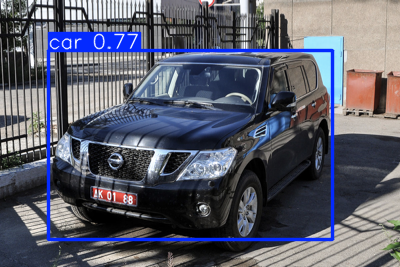

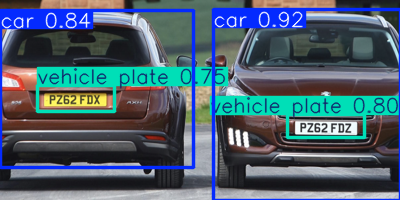

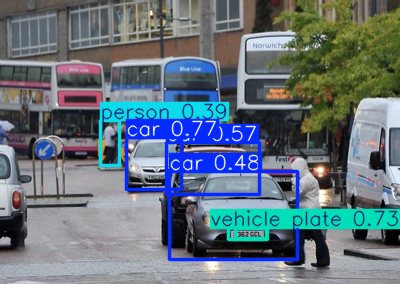

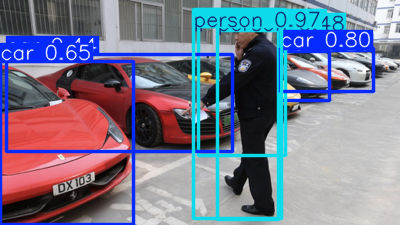

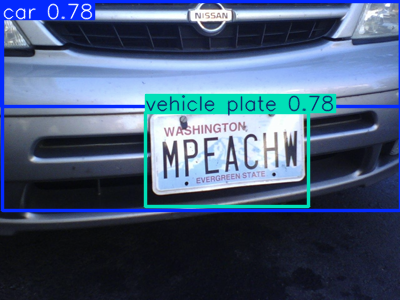

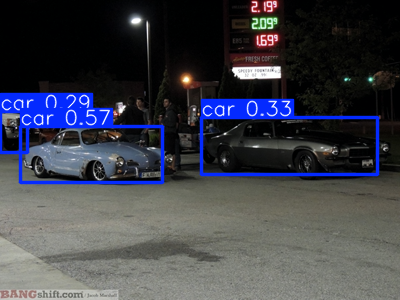

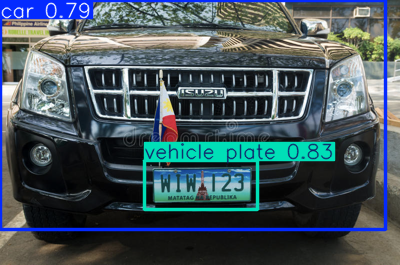

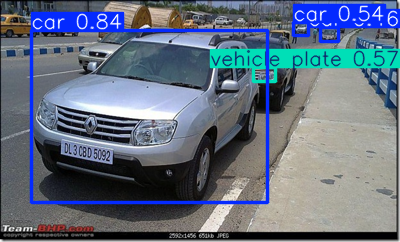

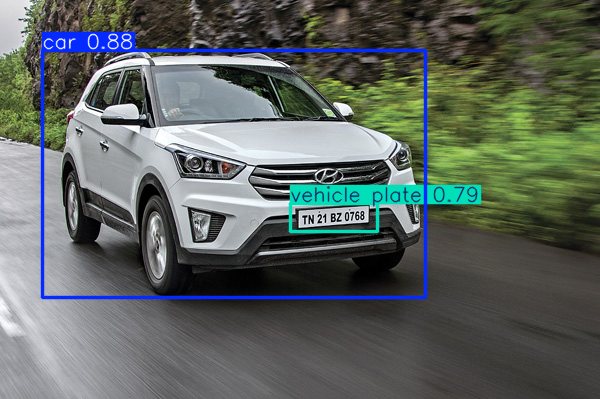

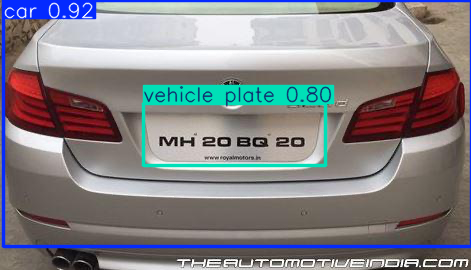

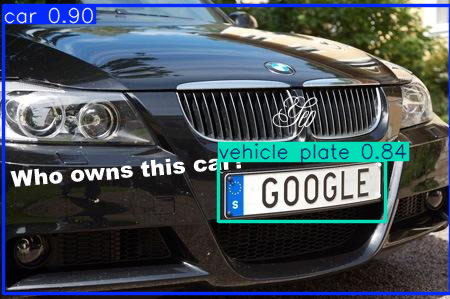

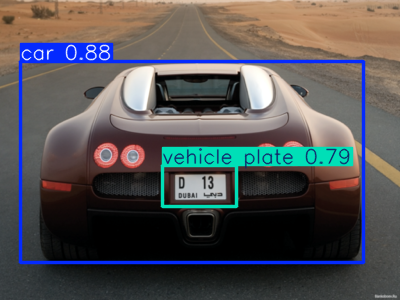

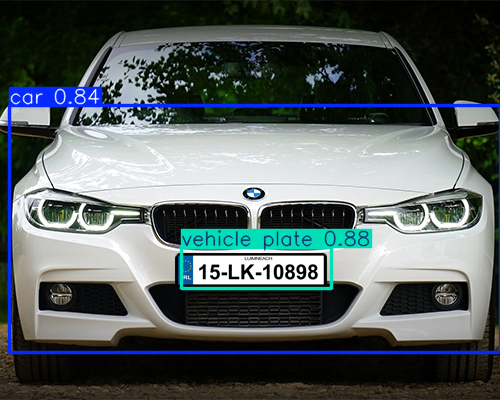

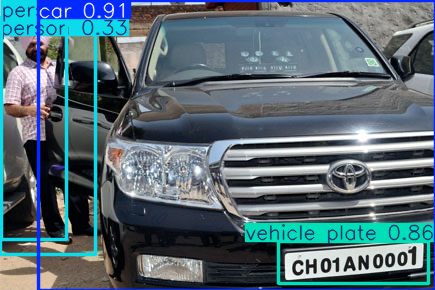

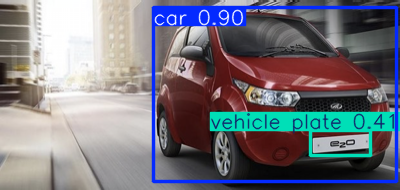

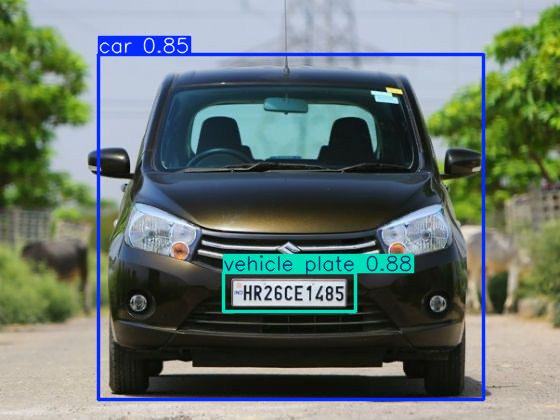

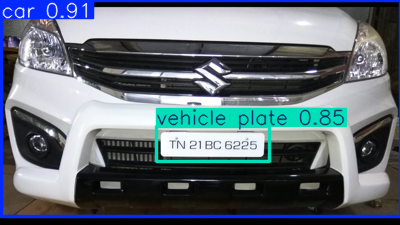

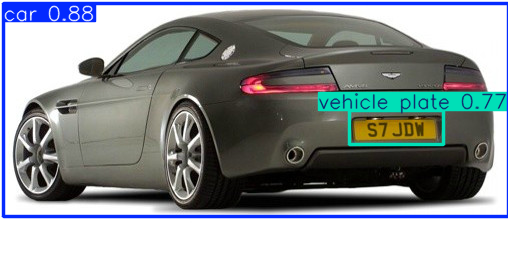

In [ ]:
image_files = glob.glob('runs/detect/predict/*.png')

for image_file in image_files:
  display(Image(filename=image_file))
  print("\n")

#Exporting The Model

Since we need to deploy it for an android app so we need a light weight model ---> TensorFlowLight :

In [ ]:
model = YOLO('./runs/detect/train/weights/best.pt')

model.export(format='tflite')

Ultralytics YOLOv8.2.81 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (21.5 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 161.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 206.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 232.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 211.4 MB/s eta

100%|██████████| 1.11M/1.11M [00:00<00:00, 26.1MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/drive/MyDrive/DEfDO_Project/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 25.55file/s]



ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: slimming with onnxslim 0.1.32...
ONNX: export success ✅ 2.4s, saved as 'runs/detect/train/weights/best.onnx' (42.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 36.3s, saved as 'runs/detect/train/weights/best_saved_model' (106.9 MB)

TensorFlow Lite: starting export with tensorflow 2.17.0...
TensorFlow Lite: export success ✅ 0.0s, saved as 'runs/detect/train/weights/best_saved_model/best_float32.tflite' (42.7 MB)

Export complete (39.0s)
Results saved to /content/drive/MyDrive/DEfDO_Project/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=640 data=my_dataset1.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best_saved_model/best_float32.tflite'

###And this is DEfDO version 1 ..  So It's recommended to rename the folder 'train' (having the model we exported) to 'train1'

#Conclusion about the results

After deploying this model on a mobile, we noticed a slow inference in its performance.
We then need to do some model compression like pruning and quantization along with conserving model's accuracy.

In order to achieve that:
1. we'll improve our dataset quality by choosing and labeling manually the relevant images.
2. we'll get a better model performance.
3. we'll do 'Quantization aware training'.
4. Get TFlite_quantized_model for deployment.


##And this is going to be in a new version on this notebook ---> DEfDO_v2.ipynb :

https://colab.research.google.com/drive/1Q5YzN5QxL0K91vpAuuc-JhfxlvJL3_bu?usp=sharing

In [ ]:
# Renaming the folder  /content/drive/MyDrive/DEfDO_Project/runs to runs1

os.rename('/content/drive/MyDrive/DEfDO_Project/runs', '/content/drive/MyDrive/DEfDO_Project/runs1')
